# Notebook 3: Feature Engineering

**Purpose**: Create statistical features, interaction features, perform feature importance screening and correlation analysis.

**Inputs**:
- `engineered_train.csv` from Notebook 2
- `engineered_test.csv` from Notebook 2

**Outputs**:
- `feature_engineered_train.csv` → `data/features/`
- `feature_engineered_test.csv` → `data/features/`
- `feature_report.json` → `results/`

---

In [19]:
# Imports
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths
BASE_DIR = Path('.').resolve().parent
SPLITS_DIR = BASE_DIR / 'data' / 'splits'
FEATURES_DIR = BASE_DIR / 'data' / 'features'
RESULTS_DIR = BASE_DIR / 'results'
FIGURES_DIR = BASE_DIR / 'figures'

# Create directories
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

# Configuration
TARGET_COLUMN = 'Class'

print(f"Random Seed: {RANDOM_SEED}")

Random Seed: 42


## 1. Load Engineered Data

In [20]:
# Load train and test data
train_df = pd.read_csv(SPLITS_DIR / 'engineered_train.csv')
test_df = pd.read_csv(SPLITS_DIR / 'engineered_test.csv')

print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (1600, 31)
Test set: (400, 31)


In [21]:
# Separate features and target
X_train = train_df.drop(columns=[TARGET_COLUMN])
y_train = train_df[TARGET_COLUMN]

X_test = test_df.drop(columns=[TARGET_COLUMN])
y_test = test_df[TARGET_COLUMN]

original_features = list(X_train.columns)
print(f"Original features: {len(original_features)}")

Original features: 30


## 2. Statistical Feature Creation

In [22]:
def create_statistical_features(df):
    """
    Create row-wise statistical features.
    """
    stats_df = pd.DataFrame(index=df.index)
    
    # Basic statistics across V1-V28 features
    v_cols = [col for col in df.columns if col.startswith('V')]
    
    stats_df['V_mean'] = df[v_cols].mean(axis=1)
    stats_df['V_std'] = df[v_cols].std(axis=1)
    stats_df['V_min'] = df[v_cols].min(axis=1)
    stats_df['V_max'] = df[v_cols].max(axis=1)
    stats_df['V_range'] = stats_df['V_max'] - stats_df['V_min']
    stats_df['V_skew'] = df[v_cols].skew(axis=1)
    stats_df['V_kurtosis'] = df[v_cols].kurtosis(axis=1)
    
    # Quantile-based features
    stats_df['V_q25'] = df[v_cols].quantile(0.25, axis=1)
    stats_df['V_q75'] = df[v_cols].quantile(0.75, axis=1)
    stats_df['V_iqr'] = stats_df['V_q75'] - stats_df['V_q25']
    
    # Count-based features
    stats_df['V_positive_count'] = (df[v_cols] > 0).sum(axis=1)
    stats_df['V_negative_count'] = (df[v_cols] < 0).sum(axis=1)
    
    return stats_df

In [23]:
# Create statistical features
stats_train = create_statistical_features(X_train)
stats_test = create_statistical_features(X_test)

print(f"Statistical features created: {stats_train.shape[1]}")
print(f"Features: {list(stats_train.columns)}")

Statistical features created: 12
Features: ['V_mean', 'V_std', 'V_min', 'V_max', 'V_range', 'V_skew', 'V_kurtosis', 'V_q25', 'V_q75', 'V_iqr', 'V_positive_count', 'V_negative_count']


## 3. Interaction Features

In [24]:
def create_interaction_features(df, top_features, n_interactions=5):
    """
    Create interaction features between top important features.
    """
    interaction_df = pd.DataFrame(index=df.index)
    
    # Select top features for interactions
    features_to_interact = top_features[:n_interactions]
    
    for i, f1 in enumerate(features_to_interact):
        for f2 in features_to_interact[i+1:]:
            # Multiplication
            interaction_df[f'{f1}_x_{f2}'] = df[f1] * df[f2]
            # Ratio (with small epsilon to avoid division by zero)
            interaction_df[f'{f1}_div_{f2}'] = df[f1] / (df[f2] + 1e-8)
    
    return interaction_df

In [25]:
# First, get feature importance to select top features for interaction
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Features by Importance:")
print(feature_importance.head(10))

Top 10 Features by Importance:
   feature  importance
14     V14    0.194266
10     V10    0.138127
17     V17    0.135880
12     V12    0.104596
16     V16    0.079943
11     V11    0.056297
3       V3    0.052796
9       V9    0.023488
6       V6    0.022791
4       V4    0.022464


In [26]:
# Create interaction features using top 5 important features
top_features = feature_importance['feature'].head(5).tolist()
print(f"Top features for interaction: {top_features}")

interaction_train = create_interaction_features(X_train, top_features)
interaction_test = create_interaction_features(X_test, top_features)

print(f"\nInteraction features created: {interaction_train.shape[1]}")

Top features for interaction: ['V14', 'V10', 'V17', 'V12', 'V16']

Interaction features created: 20


## 4. Combine All Features

In [27]:
# Combine original + statistical + interaction features
X_train_enhanced = pd.concat([X_train, stats_train, interaction_train], axis=1)
X_test_enhanced = pd.concat([X_test, stats_test, interaction_test], axis=1)

print(f"Enhanced training features: {X_train_enhanced.shape}")
print(f"Enhanced test features: {X_test_enhanced.shape}")

Enhanced training features: (1600, 62)
Enhanced test features: (400, 62)


## 5. Feature Importance Screening

In [28]:
# Recalculate feature importance with all features
rf_full = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf_full.fit(X_train_enhanced, y_train)

full_importance = pd.DataFrame({
    'feature': X_train_enhanced.columns,
    'importance': rf_full.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Features (All):")
print(full_importance.head(15))

Top 15 Features (All):
      feature  importance
14        V14    0.126626
42  V14_x_V10    0.118148
46  V14_x_V12    0.103627
50  V10_x_V17    0.074175
17        V17    0.062607
56  V17_x_V12    0.044686
58  V17_x_V16    0.037882
12        V12    0.037415
37      V_q25    0.036227
44  V14_x_V17    0.035693
60  V12_x_V16    0.034875
10        V10    0.028111
48  V14_x_V16    0.027923
11        V11    0.022887
52  V10_x_V12    0.015674


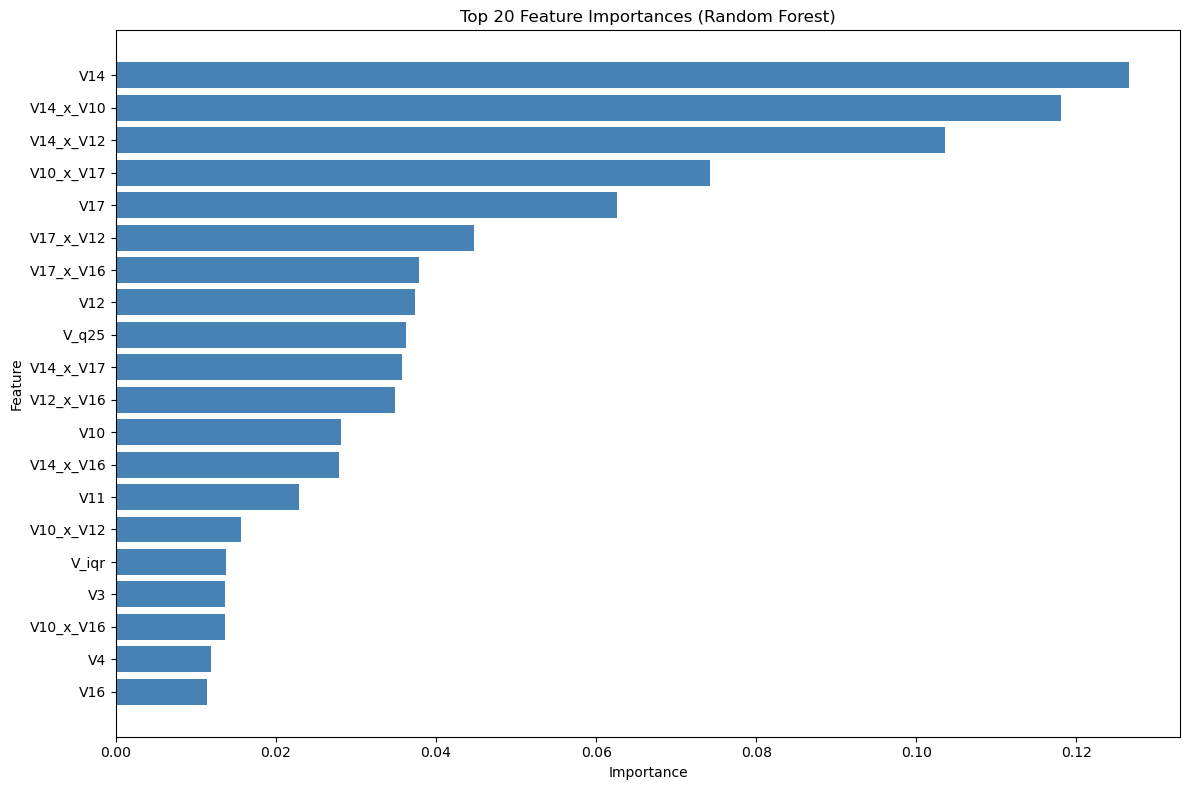

In [29]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_20 = full_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values, color='steelblue')
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'feature_importance.png', dpi=150)
plt.show()

## 6. Correlation Analysis

In [30]:
# Compute correlation with target
correlations = X_train_enhanced.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 15 Features by Correlation with Target:")
print(correlations.head(15))

Top 15 Features by Correlation with Target:
V14          0.750081
V12          0.676112
V_q25        0.661609
V_iqr        0.653003
V10          0.641432
V14_x_V10    0.635129
V17          0.612910
V14_x_V12    0.611955
V3           0.574841
V_std        0.572139
V_mean       0.571532
V10_x_V12    0.568307
V16          0.565963
V14_x_V16    0.565949
V14_x_V17    0.565200
dtype: float64


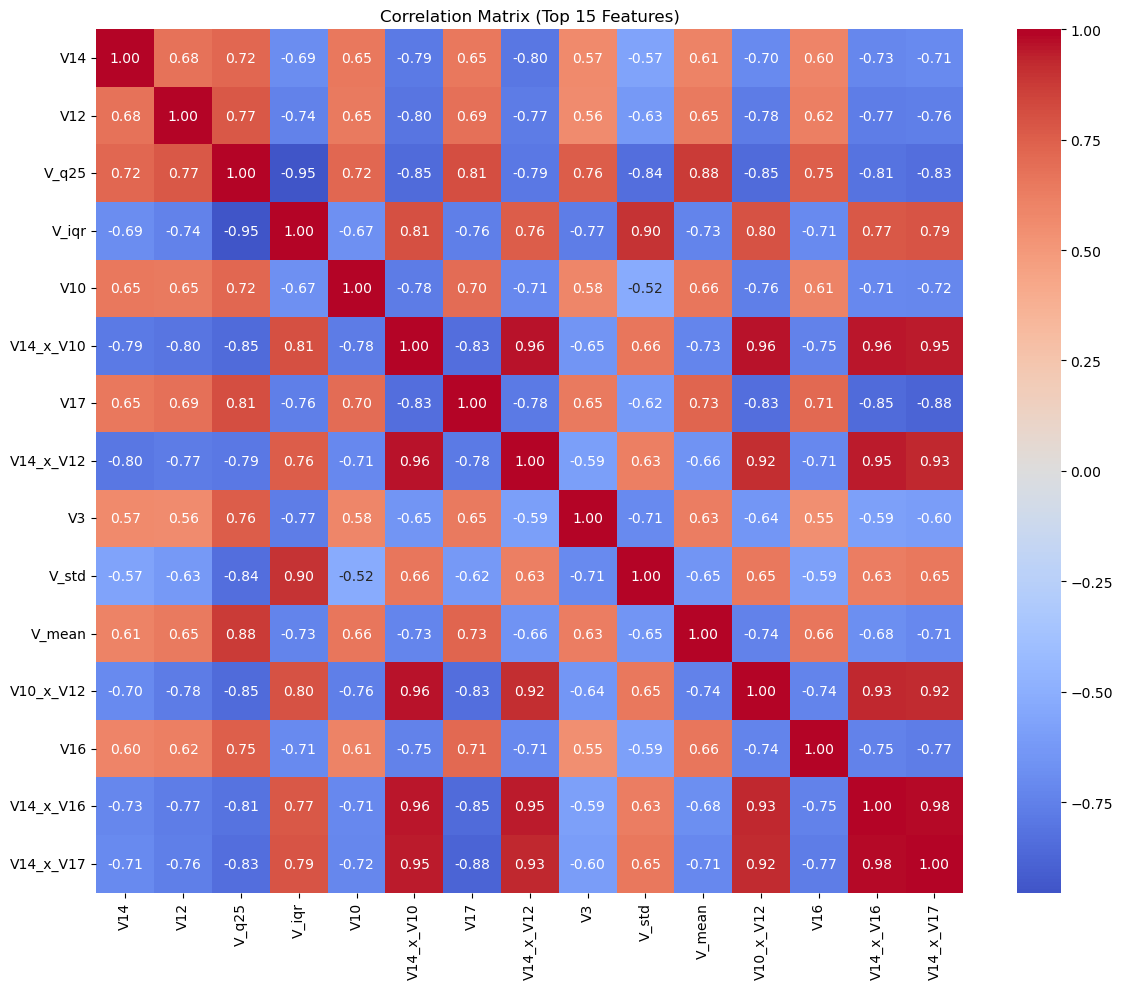

In [31]:
# Correlation heatmap for top features
top_corr_features = correlations.head(15).index.tolist()
corr_matrix = X_train_enhanced[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix (Top 15 Features)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlation_matrix.png', dpi=150)
plt.show()

## 7. Select Final Features

In [32]:
# Combine importance and correlation for feature selection
selection_df = pd.DataFrame({
    'feature': full_importance['feature'],
    'importance_rank': range(1, len(full_importance) + 1),
    'importance': full_importance['importance']
})

# Add correlation ranking
corr_df = pd.DataFrame({
    'feature': correlations.index,
    'correlation': correlations.values,
    'correlation_rank': range(1, len(correlations) + 1)
})

selection_df = selection_df.merge(corr_df, on='feature')
selection_df['combined_rank'] = (selection_df['importance_rank'] + selection_df['correlation_rank']) / 2
selection_df = selection_df.sort_values('combined_rank')

print("Top 20 Features by Combined Ranking:")
print(selection_df.head(20))

Top 20 Features by Combined Ranking:
      feature  importance_rank  importance  correlation  correlation_rank  \
0         V14                1    0.126626     0.750081                 1   
1   V14_x_V10                2    0.118148     0.635129                 6   
7         V12                8    0.037415     0.676112                 2   
2   V14_x_V12                3    0.103627     0.611955                 8   
4         V17                5    0.062607     0.612910                 7   
8       V_q25                9    0.036227     0.661609                 3   
11        V10               12    0.028111     0.641432                 5   
15      V_iqr               16    0.013701     0.653003                 4   
3   V10_x_V17                4    0.074175     0.534453                21   
9   V14_x_V17               10    0.035693     0.565200                15   
5   V17_x_V12                6    0.044686     0.541357                20   
16         V3               17    0.013

In [33]:
# Select top features (keeping all for now, dimensionality reduction in Notebook 4)
# Here we just ensure features are well-formed
selected_features = X_train_enhanced.columns.tolist()

X_train_final = X_train_enhanced[selected_features]
X_test_final = X_test_enhanced[selected_features]

print(f"Final feature count: {len(selected_features)}")

Final feature count: 62


## 8. Save Outputs

In [34]:
# Combine with target and save
train_final = X_train_final.copy()
train_final[TARGET_COLUMN] = y_train.values

test_final = X_test_final.copy()
test_final[TARGET_COLUMN] = y_test.values

# Save
train_path = FEATURES_DIR / 'feature_engineered_train.csv'
test_path = FEATURES_DIR / 'feature_engineered_test.csv'

train_final.to_csv(train_path, index=False)
test_final.to_csv(test_path, index=False)

print(f"✅ Saved feature-engineered training data to: {train_path}")
print(f"✅ Saved feature-engineered test data to: {test_path}")

✅ Saved feature-engineered training data to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\data\features\feature_engineered_train.csv
✅ Saved feature-engineered test data to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\data\features\feature_engineered_test.csv


In [35]:
# Create and save feature report
feature_report = {
    "random_seed": RANDOM_SEED,
    "original_features": len(original_features),
    "statistical_features": stats_train.shape[1],
    "interaction_features": interaction_train.shape[1],
    "total_features": len(selected_features),
    "feature_names": selected_features,
    "top_10_by_importance": full_importance.head(10).to_dict('records'),
    "top_10_by_correlation": [
        {"feature": f, "correlation": round(c, 4)} 
        for f, c in zip(correlations.head(10).index, correlations.head(10).values)
    ],
    "engineering_steps": [
        "Created row-wise statistical features (mean, std, skew, kurtosis, etc.)",
        "Created interaction features (multiplication, division) for top 5 features",
        "Computed Random Forest feature importance",
        "Computed correlation with target"
    ]
}

report_path = RESULTS_DIR / 'feature_report.json'
with open(report_path, 'w') as f:
    json.dump(feature_report, f, indent=2)

print(f"✅ Saved feature report to: {report_path}")

✅ Saved feature report to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\results\feature_report.json


## 9. Verification

In [36]:
# Verify
train_verify = pd.read_csv(FEATURES_DIR / 'feature_engineered_train.csv')
test_verify = pd.read_csv(FEATURES_DIR / 'feature_engineered_test.csv')

print("Verification:")
print(f"  Training shape: {train_verify.shape}")
print(f"  Test shape: {test_verify.shape}")
print(f"  Feature columns: {len(train_verify.columns) - 1}")
print("\n✅ Notebook 3 Complete!")

Verification:
  Training shape: (1600, 63)
  Test shape: (400, 63)
  Feature columns: 62

✅ Notebook 3 Complete!
